In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from src.preprocessing import read_transactions, create_feature_processor

# Path config
DATA_PATH = "data/transactions.csv"
MODEL_PATH = "models/fraud_model.pkl"

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

pip install pandas numpy joblib shap matplotlib scikit-learn imbalanced-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
X, y = read_transactions(DATA_PATH)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

preprocessor = create_feature_processor()


Train: (629145, 9) Val: (209715, 9) Test: (209715, 9)


In [4]:
models = {
    "LogReg": (
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"),
        {"model__C": np.logspace(-3, 3, 5), "model__penalty": ["l1", "l2"]}
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {"model__n_estimators": [100, 200], "model__max_depth": [10, 20, None]}
    ),
    "XGBoost": (
        XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            scale_pos_weight=10,
            random_state=42
        ),
        {"model__n_estimators": [100, 200], "model__max_depth": [3, 5, 10]}
    ),
}


In [5]:
best_model = None
best_score = -1
results = []

for name, (model, param_grid) in models.items():
    print(f"\n=== Training {name} ===")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy=0.5, random_state=42)),
        ("model", model)
    ])
    
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=5,
        scoring="average_precision",
        cv=3,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    
    y_val_pred = search.predict(X_val)
    y_val_proba = search.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, y_val_proba)
    
    print(classification_report(y_val, y_val_pred))
    print("Validation PR AUC:", pr_auc)
    
    results.append((name, pr_auc))
    
    if pr_auc > best_score:
        best_score = pr_auc
        best_model = search.best_estimator_

print("\n=== Model Comparison ===")
for name, score in results:
    print(f"{name}: PR AUC = {score:.4f}")
print("Best model:", best_model.named_steps["model"].__class__.__name__)




=== Training LogReg ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    209486
           1       0.02      0.97      0.03       229

    accuracy                           0.94    209715
   macro avg       0.51      0.96      0.50    209715
weighted avg       1.00      0.94      0.97    209715

Validation PR AUC: 0.44996728421005794

=== Training RandomForest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209486
           1       0.25      0.88      0.39       229

    accuracy                           1.00    209715
   macro avg       0.63      0.94      0.70    209715
weighted avg       1.00      1.00      1.00    209715

Validation PR AUC: 0.8401499254195715

=== Training XGBoost ===


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [13:19:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209486
           1       0.22      0.93      0.36       229

    accuracy                           1.00    209715
   macro avg       0.61      0.96      0.68    209715
weighted avg       1.00      1.00      1.00    209715

Validation PR AUC: 0.8599164154206248

=== Model Comparison ===
LogReg: PR AUC = 0.4500
RandomForest: PR AUC = 0.8401
XGBoost: PR AUC = 0.8599
Best model: XGBClassifier


In [6]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

best_model.fit(X_trainval, y_trainval)

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [13:20:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Final Test Report ===")
print(classification_report(y_test, y_test_pred))
print("Test PR AUC:", average_precision_score(y_test, y_test_proba))


=== Final Test Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.23      0.93      0.37       228

    accuracy                           1.00    209715
   macro avg       0.62      0.96      0.69    209715
weighted avg       1.00      1.00      1.00    209715

Test PR AUC: 0.8493527217473605


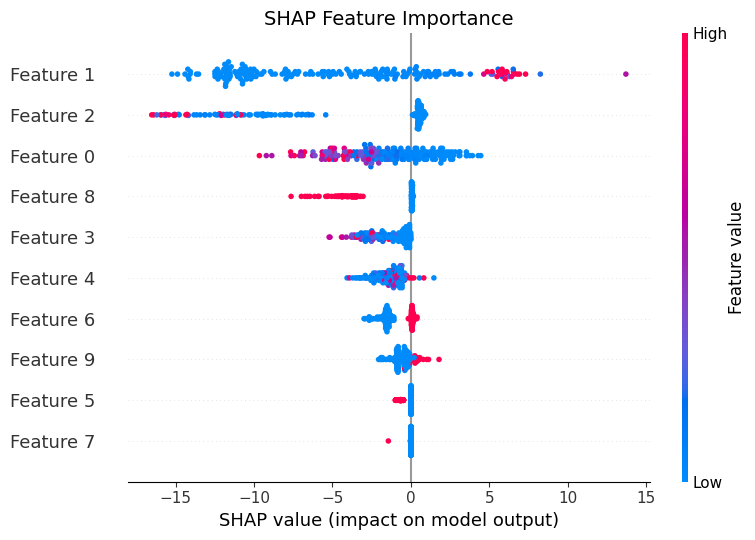

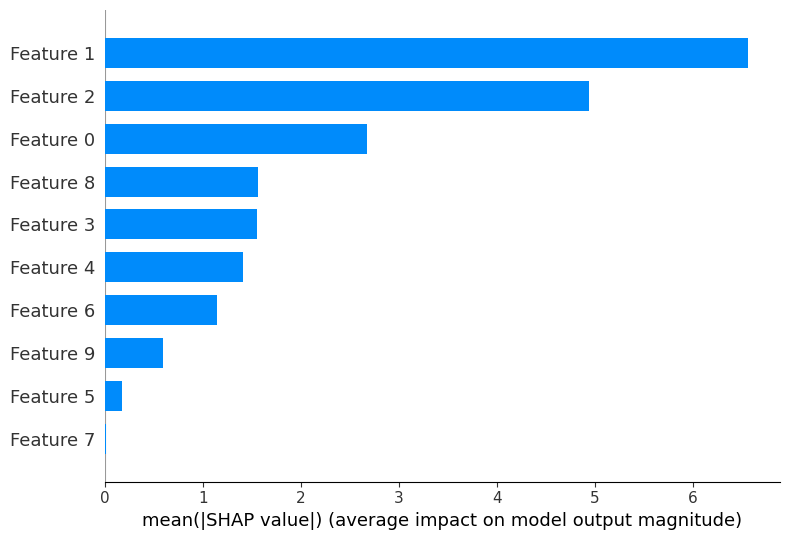

 SHAP plots saved in: results/shap_plots


In [8]:
from src.shap_analysis import run_shap_analysis

X_sample = X_val.sample(n=200, random_state=42)
shap_values=run_shap_analysis(best_model, X_sample,save_dir="results/shap_plots")

In [9]:
joblib.dump(best_model, MODEL_PATH)
print(f" Best pipeline saved to {MODEL_PATH}")

 Best pipeline saved to models/fraud_model.pkl
